24520270 - Huỳnh Phát Đạt  
DS201.Q11.1  
Bài thực hành số 3

## Import thư viện


In [ ]:
!pip install tensorflow

In [ ]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00


In [ ]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=062470b7a4fabb74d8e8d9e1282419ef84aff56f7c1a3682bed859e3019e2a54
  Stored in directory: /root/.cache/pip/wheels/6f/19/20/ec7083125fd06db1a19d0d3ca18806ecf4e8ed1464713b4efa
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2025-11-28 14:01:48--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  80.6MB/s    in 0.3s    

2025-11-28 14:01:50 (80.6 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-11-28 14:01:50--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 40.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

import re
import unicodedata

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from vncorenlp import VnCoreNLP
from pyvi import ViTokenizer
from underthesea import word_tokenize

### Khởi tạo VnCoreNLP

In [ ]:
vncorenlp = VnCoreNLP(
    "/content/vncorenlp/VnCoreNLP-1.1.1.jar",
    annotators="wseg",
    max_heap_size='-Xmx500m'
)

# hàm tách từ
# def custom_tokenizer(text):
#     tokens = vncorenlp.tokenize(str(text))[0]
#     return " ".join(tokens)

## Chuẩn bị UIT-VSFC dataset


### Đọc dữ liệu

In [ ]:
train_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-train.json')
dev_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-dev.json')
test_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-test.json')

In [ ]:
train_vsfc.head()

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,positive,training_program
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,lecturer
2,đi học đầy đủ full điểm chuyên cần .,negative,training_program
3,chưa áp dụng công nghệ thông tin và các thiết ...,negative,lecturer
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,lecturer


In [ ]:
X_train_vsfc = train_vsfc['sentence']
y_train_vsfc = train_vsfc['sentiment']

x_dev_vsfc = dev_vsfc['sentence']
y_dev_vsfc = dev_vsfc['sentiment']

x_test_vsfc = test_vsfc['sentence']
y_test_vsfc = test_vsfc['sentiment']

### Tiền xử lý dữ liệu

In [ ]:
# hàm replace giá trị trong tập label
def encode_sentiment(series):
  mapping = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
  }
  encoded_series = series.astype(str).str.strip().str.lower().map(mapping)

  if encoded_series.isnull().any():
      print(f"Warning: {encoded_series.isnull().sum()} NaN values found after encoding sentiments label")

  return encoded_series

In [ ]:
y_train_vsfc = encode_sentiment(y_train_vsfc).astype(int)
y_dev_vsfc = encode_sentiment(y_dev_vsfc).astype(int)
y_test_vsfc = encode_sentiment(y_test_vsfc).astype(int)

In [ ]:
# hàm chuẩn hóa các câu bình luận - sentence
def clean_text(text):
  text = unicodedata.normalize("NFC", text)
  text = text.lower()
  text = re.sub(r"[^\w\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()

  # thử nghiệm tách từ với nhiều thư viện khác nhau
  # tách từ với underthesea hiện tại chạy cho ra kết quả tốt nhất

  # text = ViTokenizer.tokenize(text) #pyvi

  text = word_tokenize(text, format="text") #underthesea

  # vncorenlp
  # text = vncorenlp.tokenize(text)
  # text = text[0]
  # text = " ".join(text)

  return text

X_train_vsfc = X_train_vsfc.apply(clean_text)
x_dev_vsfc = x_dev_vsfc.apply(clean_text)
x_test_vsfc = x_test_vsfc.apply(clean_text)

In [ ]:
X_train_vsfc.head()

,sentence
0,slide giáo_trình đầy_đủ
1,nhiệt_tình giảng_dạy gần_gũi với sinh_viên
2,đi học đầy_đủ full_điểm chuyên cần
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...
4,thầy giảng bài hay có nhiều bài_tập ví_dụ ngay...


### Xây dựng bộ từ vựng, word_to_index

In [ ]:
MAX_LEN = 50
NUM_LABEL = 3

word_tokenizer = Tokenizer(oov_token='UNK')
word_tokenizer.fit_on_texts(X_train_vsfc)

# tạo word_to_index
word2index = word_tokenizer.word_index
word2index['PAD'] = 0

index_to_word = {i: w for w, i in word2index.items()}

### Encode dữ liệu

In [ ]:
# hàm encode tập data
def encoding(X, y):
  sentences = word_tokenizer.texts_to_sequences(X)
  X = pad_sequences(sentences, maxlen=MAX_LEN, padding='post', value=word2index['PAD'])

  y = to_categorical(y, num_classes=NUM_LABEL)

  return (X, y)

In [ ]:
X_train_encoded, y_train_encoded = encoding(X_train_vsfc, y_train_vsfc)
x_dev_encoded, y_dev_encoded = encoding(x_dev_vsfc, y_dev_vsfc)
x_test_encoded, y_test_encoded = encoding(x_test_vsfc, y_test_vsfc)

In [ ]:
print(X_train_encoded)

[[ 120   46   52 ...    0    0    0]
 [  14    9    3 ...    0    0    0]
 [ 100    7  123 ...    0    0    0]
 ...
 [ 333    8   18 ...    0    0    0]
 [  46    2    4 ...    0    0    0]
 [1293  505  293 ...    0    0    0]]


In [ ]:
print(y_train_encoded)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


## Bài 1: Xây dựng mạng LSTM gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xây dựng model

In [ ]:
# Xây dựng model
model_1 = Sequential()
model_1.add(Input(shape=(MAX_LEN, )))
model_1.add(Embedding(input_dim=len(word2index), output_dim=300, input_length=MAX_LEN))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256))
model_1.add(Dense(NUM_LABEL, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_1.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 50, 300)        │       740,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 50, 256)        │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,412,787 (13.02 MB)

 Trainable params: 3,412,787 (13.02 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()

model_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
call_back = EarlyStopping(monitor='val_loss', patience=3)

# Train model
history_1 = model_1.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    batch_size=32,
    epochs=30,
    callbacks=call_back,
    validation_data=(x_dev_encoded, y_dev_encoded)
)

Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.4809 - loss: 0.8581 - val_accuracy: 0.5085 - val_loss: 0.8489
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5107 - loss: 0.8200 - val_accuracy: 0.7694 - val_loss: 0.5995
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7368 - loss: 0.6270 - val_accuracy: 0.7934 - val_loss: 0.6009
Epoch 4/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8122 - loss: 0.5645 - val_accuracy: 0.8686 - val_loss: 0.4612
Epoch 5/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8799 - loss: 0.4035 - val_accuracy: 0.8977 - val_loss: 0.3538
Epoch 6/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9037 - loss: 0.3193 - val_accuracy: 0.9027 - val_loss: 0.3279
Epoch 7/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9161 - loss: 0.2793 - val_accuracy: 0.8964 - val_loss: 0.3504
Epoch 8/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9111 - loss: 0.2864 - val_ac

### Đánh giá

In [ ]:
# Predict
y_pred1_vsfc = model_1.predict(x_test_encoded)
y_pred1_vsfc = np.argmax(y_pred1_vsfc, axis=1)

print('F1 Score:', f1_score(y_test_vsfc, y_pred1_vsfc, average='macro'))

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
F1 Score: 0.7436877167164758


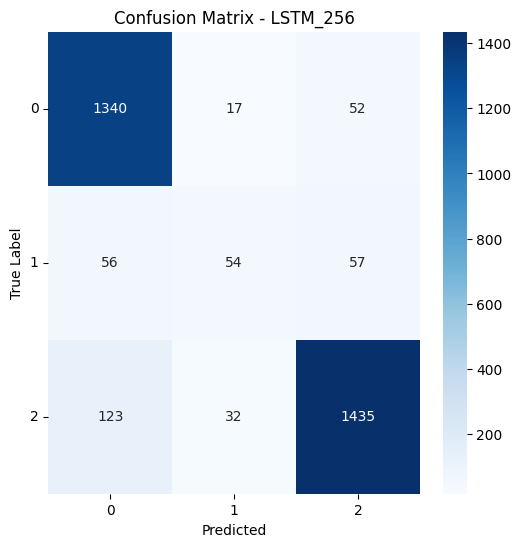

In [ ]:
# Confunsion Matrix
cm = confusion_matrix(y_test_vsfc, y_pred1_vsfc)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - LSTM_256')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.ylabel('True Label')
plt.show()

In [ ]:
# save model
model_1.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_1.h5')

## Bài 2: Xây dựng mạng GRU gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xây dựng model

In [ ]:
# xây dựng model
model_2 = Sequential()
model_2.add(Input(shape=(MAX_LEN, )))
model_2.add(Embedding(input_dim=len(word2index), output_dim=300, input_length=MAX_LEN))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256))
model_2.add(Dense(NUM_LABEL, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 50, 300)        │       740,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 50, 256)        │       428,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 50, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,748,723 (10.49 MB)

 Trainable params: 2,748,723 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()

model_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
call_back = EarlyStopping(monitor='val_loss', patience=3)

# train model_2
history_2 = model_2.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    batch_size=32,
    epochs=30,
    callbacks=call_back,
    validation_data=(x_dev_encoded, y_dev_encoded)
)

Epoch 1/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9612 - loss: 0.1259 - val_accuracy: 0.9147 - val_loss: 0.2758
Epoch 2/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9669 - loss: 0.1096 - val_accuracy: 0.9135 - val_loss: 0.3052
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9659 - loss: 0.1112 - val_accuracy: 0.9109 - val_loss: 0.3297
Epoch 4/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9681 - loss: 0.1055 - val_accuracy: 0.9084 - val_loss: 0.3302


### Đánh giá

In [ ]:
# Predict
y_pred2_vsfc = model_2.predict(x_test_encoded)
y_pred2_vsfc = np.argmax(y_pred2_vsfc, axis=1)

print('F1 Score:', f1_score(y_test_vsfc, y_pred2_vsfc, average='macro'))

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
F1 Score: 0.7561897317350379


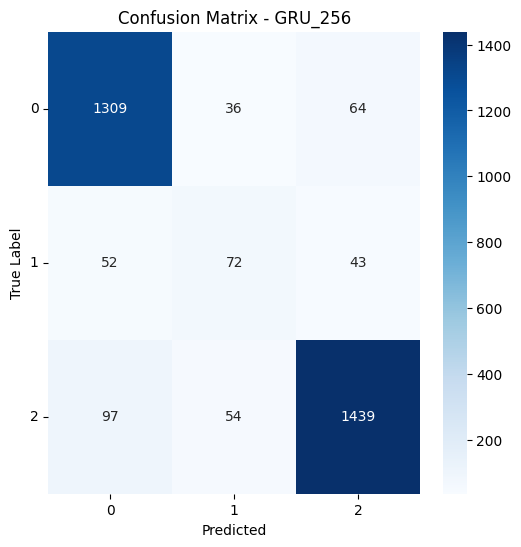

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_vsfc, y_pred2_vsfc)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - GRU_256')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.ylabel('True Label')
plt.show()

In [ ]:
# save model
model_2.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_2.h5')

## Chuẩn bị PhoNER dataset



In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 61 (delta 24), reused 41 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 3.61 MiB | 21.76 MiB/s, done.
Resolving deltas: 100% (24/24), done.


### Đọc dữ liệu

In [ ]:
train = pd.read_json('/content/PhoNER_COVID19/data/word/train_word.json', lines=True)
dev = pd.read_json('/content/PhoNER_COVID19/data/word/dev_word.json', lines=True)
test = pd.read_json('/content/PhoNER_COVID19/data/word/test_word.json', lines=True)

In [ ]:
train.head()

,words,tags
0,"[Đồng_thời, ,, bệnh_viện, tiếp_tục, thực_hiện,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"["", Số, bệnh_viện, có_thể, tiếp_nhận, bệnh_nhâ...","[O, O, O, O, O, O, O, B-SYMPTOM_AND_DISEASE, I..."
2,"[Ngoài_ra, ,, những, người, tiếp_xúc, gián_tiế...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Bà, này, khi, trở, về, quá_cảnh, Doha, (, Qat...","[O, O, O, O, O, O, B-LOCATION, O, B-LOCATION, ..."
4,"["", Bệnh_nhân, 523, "", và, chồng, là, "", bệnh_...","[O, O, B-PATIENT_ID, O, O, O, O, O, O, B-PATIE..."


In [ ]:
X_train_PhoNER = train['words']
y_train_PhoNER = train['tags']

X_dev_PhoNER = dev['words']
y_dev_PhoNER = dev['tags']

X_test_PhoNER = test['words']
y_test_PhoNER = test['tags']

### Xây dựng bộ từ vựng, tag, word_to_index, tag_to_index

In [ ]:
# Xây dựng bộ từ vựng
word_dict1 = set()

for word in X_train_PhoNER:
  for w in word:
    word_dict1.add(w)

word_dict1 = {'<PAD>', '<UNK>'} | word_dict1
word1 = list(word_dict1)

# Tạo word2index
word2index1 = {w:i for i, w in enumerate(word1)}

In [ ]:
# Xây dựng bộ tag
tag_dict1 = set()

for tag in y_train_PhoNER:
  for t in tag:
    tag_dict1.add(t)

tag_dict1 = {'<PAD>'} | tag_dict1
tag1 = list(tag_dict1)

# Tạo tag2index
tag2index1 = {t:i for i, t in enumerate(sorted(tag1))}

### Encode dữ liệu

In [ ]:
MAX_LEN1 = 80

def encoding1(X, y):
    # Encode words
    X_encoded = [
        [word2index1.get(w, word2index1["<UNK>"]) for w in sent]
        for sent in X
    ]

    X = pad_sequences(sequences=X_encoded, maxlen=MAX_LEN1,
                      padding="post", value=word2index1["<PAD>"]
    )

    # Encode tags
    y_encoded = [
        [tag2index1[t] for t in tags]
        for tags in y
    ]

    y = pad_sequences(sequences=y_encoded, maxlen=MAX_LEN1,
                      padding="post", value=tag2index1["<PAD>"]
    )

    return X, y

In [ ]:
X_train_encoded1, y_train_encoded1 = encoding1(X_train_PhoNER, y_train_PhoNER)
X_dev_encoded1, y_dev_encoded1 = encoding1(X_dev_PhoNER, y_dev_PhoNER)
X_test_encoded1, y_test_encoded1 = encoding1(X_test_PhoNER, y_test_PhoNER)

In [ ]:
print(X_train_encoded1.shape)  # (num_samples, MAX_LEN1)
print(y_train_encoded1.shape)  # (num_samples, MAX_LEN1)

(5027, 80)
(5027, 80)


## Bài 3: Xây dựng kiến trúc Encoder trong đó Encoder gồm 5 lớp BiLSTM với hidden size là 256 cho bài toán nhận diện thực thể (Name Entity Recognition). Huấn luyện mô hình trên bộ dữ liệu PhoNER và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xậy dựng model

In [ ]:
model_3 = Sequential()
model_3.add(Input(shape=(MAX_LEN1, )))
model_3.add(Embedding(input_dim=len(word2index1), output_dim=128))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(TimeDistributed(Dense(len(tag2index1), activation='softmax')))

In [ ]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 128)        │       671,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 512)        │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 80, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 80, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 80, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 80, 21)         │        10,773 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,770,005 (29.64 MB)

 Trainable params: 7,770,005 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = SparseCategoricalCrossentropy()

model_3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# sử dụng early stopping dựa trên val_loss
callback = EarlyStopping(monitor='val_loss', patience=5)

# train model
history_3 = model_3.fit(
    x=X_train_encoded1,
    y=y_train_encoded1,
    batch_size=32,
    epochs=20,
    callbacks=[callback],
    validation_data=(X_dev_encoded1, y_dev_encoded1)
)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.8665 - loss: 0.5668 - val_accuracy: 0.9168 - val_loss: 0.3199
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9445 - loss: 0.2031 - val_accuracy: 0.9504 - val_loss: 0.1726
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9773 - loss: 0.0765 - val_accuracy: 0.9791 - val_loss: 0.0839
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9902 - loss: 0.0347 - val_accuracy: 0.9813 - val_loss: 0.0726
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9932 - loss: 0.0236 - val_accuracy: 0.9811 - val_loss: 0.0757
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9952 - loss: 0.0169 - val_accuracy: 0.9842 - val_loss: 0.0678
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9850 - val_loss: 0.0662
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.9967 - loss: 0.0116 -

### Đánh giá

In [ ]:
# Predict
y_pred3_PhoNER = model_3.predict(X_test_encoded1)
y_pred3_PhoNER = np.argmax(y_pred3_PhoNER, axis=2)

y_true = []
y_pred = []

for true, pred in zip(y_test_encoded1, y_pred3_PhoNER):
  for t, p in zip(true, pred):
    if t != tag2index1['<PAD>']: # bỏ qua padding
      y_true.append(t)
      y_pred.append(p)

print('F1 Score:', f1_score(y_true, y_pred, average='macro'))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
F1 Score: 0.6961372215908217


In [ ]:
# Tạo index_to_tag
idx2tag = {i: t for t, i in tag2index1.items()}

y_true_tags = [idx2tag[i] for i in y_true]
y_pred_tags = [idx2tag[i] for i in y_pred]

# Classification report
print(classification_report(y_true_tags, y_pred_tags, digits=4, zero_division=0))

                       precision    recall  f1-score   support

                B-AGE     0.8736    0.9613    0.9153       568
               B-DATE     0.8862    0.9714    0.9268      1643
             B-GENDER     0.8663    0.9418    0.9025       447
                B-JOB     0.4778    0.5000    0.4886       172
           B-LOCATION     0.9541    0.8582    0.9036      4428
               B-NAME     0.7031    0.5660    0.6272       318
       B-ORGANIZATION     0.8369    0.8205    0.8286       769
         B-PATIENT_ID     0.8669    0.9566    0.9096      1982
B-SYMPTOM_AND_DISEASE     0.8084    0.8504    0.8288      1136
     B-TRANSPORTATION     0.8446    0.8446    0.8446       193
                I-AGE     0.0000    0.0000    0.0000         6
               I-DATE     0.9017    0.9919    0.9447      1730
                I-JOB     0.4368    0.3333    0.3781       114
           I-LOCATION     0.9586    0.8133    0.8800      4900
               I-NAME     0.4000    0.4615    0.4286  

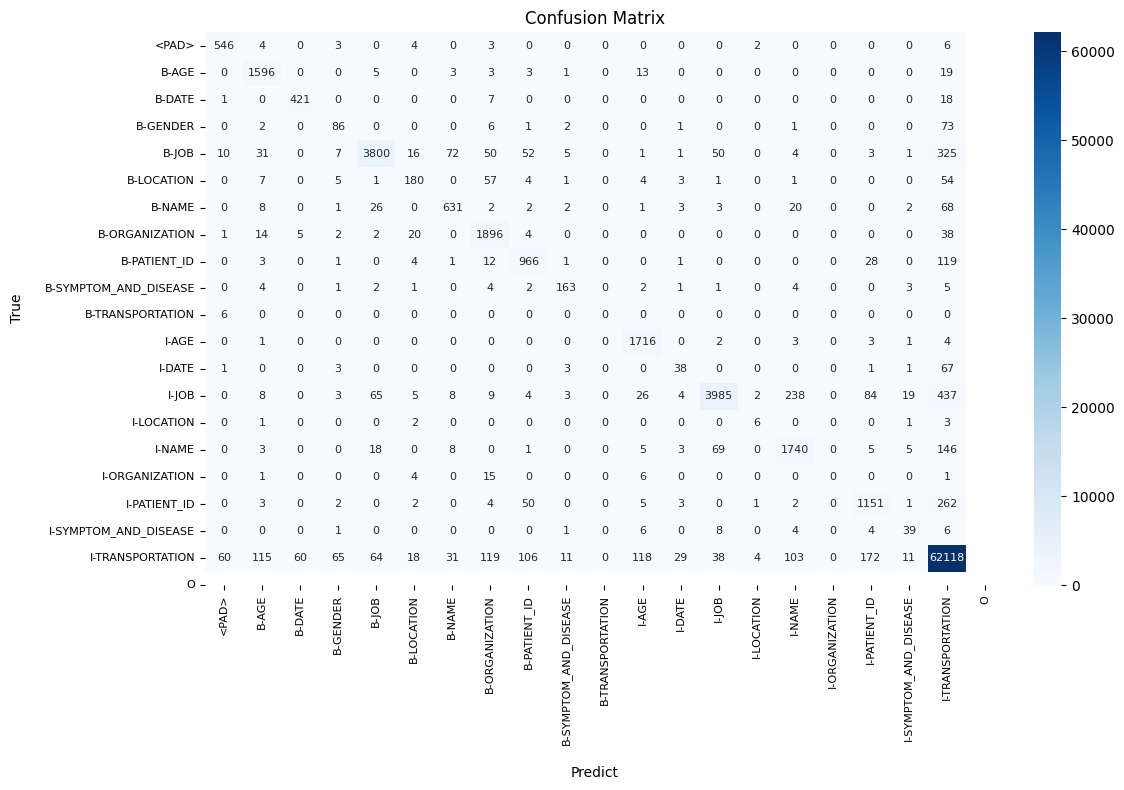

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_tags, y_pred_tags)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":8},
            xticklabels=list(tag2index1.keys()), yticklabels=list(tag2index1.keys()))
plt.xlabel("Predict", labelpad=15)
plt.ylabel("True", labelpad=15)
plt.xticks(size=8)
plt.yticks(size=8)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# save model
#model_3.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_3.h5')